In [1]:
# If you're using Google Colab, please run these commands first
# !wget https://github.com/dvgodoy/PyTorch101_AI_Plus/raw/main/quiz.zip -O quiz.zip
# !unzip -qo quiz.zip
# !wget https://raw.githubusercontent.com/dvgodoy/PyTorch101_AI_Plus/main/simple_linear_regression.py -O simple_linear_regression.py

In [3]:
from IPython.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))
from quiz.jupyterquiz import display_quiz

# Module 4

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
%run -i simple_linear_regression.py

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

## Model: making predictions

In PyTorch, a **model** is represented by a regular **Python class** that inherits from the [**Module**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class.

The most fundamental methods it needs to implement are:

* **`__init__(self)`**: **it defines the parts that make up the model** —in our case, two parameters, **b** and **w**.

* **`forward(self, x)`**: it performs the **actual computation**, that is, it **outputs a prediction**, given the input **x**.

Let’s build a proper (yet simple) model for our regression task. It should look like this:

In [17]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        b = torch.randn(1, requires_grad=True, dtype=torch.float)
        w = torch.randn(1, requires_grad=True, dtype=torch.float)

        # To make "b" and "w" real parameters of the model, we need to wrap them with nn.Parameter
        self.b = nn.Parameter(b)
        self.w = nn.Parameter(w)
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.w * x

### Parameter


In the **\__init__** method, we define our **two parameters**, **b** and **w**, using the [**Parameter()**](https://bit.ly/309iFQ6) class, to tell PyTorch these **tensors should be considered parameters of the model they are an attribute of**.

Why should we care about that? By doing so, we can use our model’s [**parameters()**](https://bit.ly/3jT0Hte[) method to retrieve **an iterator over all model’s parameters**, even those parameters of **nested models**, that we can use to feed our optimizer (instead of building a list of parameters ourselves!).

In [18]:
dummy = ManualLinearRegression()

list(dummy.parameters())

[Parameter containing:
 tensor([0.2345], requires_grad=True),
 Parameter containing:
 tensor([0.2303], requires_grad=True)]

Moreover, we can get the **current values for all parameters** using our model’s [**state_dict()**](https://bit.ly/3f8mnOs) method.

In [19]:
dummy.state_dict()

OrderedDict([('b', tensor([0.2345])), ('w', tensor([0.2303]))])

### state_dict

The **state_dict()** of a given model is simply a Python dictionary that **maps each layer / parameter to its corresponding tensor**. But only **learnable** parameters are included, as its purpose is to keep track of parameters that are going to be updated by the **optimizer**.

The **optimizer** itself also has a **state_dict()**, which contains its internal state, as well as the hyperparameters used.

---

It turns out **state_dicts** can also be used for **checkpointing** a model, as we will see later down the line.

---

In [20]:
optimizer = optim.SGD(dummy.parameters(), lr=1e-1)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1]}]}

### Device

**IMPORTANT**: we need to **send our model to the same device where the data is**. If our data is made of GPU tensors, our model must “live” inside the GPU as well.

In [22]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)

# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([0.3367], device='cuda:0')), ('w', tensor([0.1288], device='cuda:0'))])


### Forward Pass

The **forward pass** is the moment when the model **makes predictions**.

---

You should **NOT call the `forward(x)`** method, though. You should **call the whole model itself**, as in **`model(x)`** to perform a forward pass and output predictions.

---

Otherwise, your model's _hooks_ will not work (if you have them)

In [23]:
yhat = model(x_train_tensor)

### train

<h2><b><i>"What does train() do? It only sets the mode!"</b></i></h2>

In PyTorch, models have a [**train()**](https://bit.ly/30VW2Ox) method which, somewhat disappointingly, **does NOT perform a training step**. Its only purpose is to **set the model to training mode**. 

Why is this important? Some models may use mechanisms like [**Dropout**](https://bit.ly/2X7v5pU), for instance, which have **distinct behaviors in training and evaluation phases**.

In [24]:
lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
# Now the optimizers uses the parameters from the model
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Sets model to training mode
    model.train()

    # Step 1
    # No more manual prediction!
    # yhat = b + w * x_tensor
    yhat = model(x_train_tensor)
    
    # Step 2
    loss = loss_fn(yhat, y_train_tensor)
    # Step 3
    loss.backward()
    # Step 4
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


Now, the printed statements will look like this — final values for parameters **b** and **w** are still the same, so everything is ok :-)

### Nested Models

In our model, we manually created two parameters to perform a linear regression. 

---

You are **not** limited to defining parameters, though… **models can contain other models as its attributes** as well, so you can easily nest them. We’ll see an example of this shortly as well.

---

Let’s use PyTorch’s [**Linear**](https://bit.ly/2Ezu181) model as an attribute of our own, thus creating a nested model.

Even though this clearly is a contrived example, as we are pretty much wrapping the underlying model without adding anything useful (or, at all!) to it, it illustrates well the concept.

In the **`__init__`** method, we created an attribute that contains our **nested `Linear` model**.

In the **`forward()`** method, we **call the nested model itself** to perform the forward pass (notice, we are **not** calling `self.linear.forward(x)`!).

In [25]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

Now, if we call the **parameters()** method of this model, **PyTorch will figure the parameters of its attributes in a recursive way**.

You can also add new `Linear` attributes and, even if you don’t use them at all in the forward pass, they will **still** be listed under `parameters()`.

In [26]:
dummy = LayerLinearRegression()

list(dummy.parameters())

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([0.2018], requires_grad=True)]

In [27]:
dummy.state_dict()

OrderedDict([('linear.weight', tensor([[-0.2191]])),
             ('linear.bias', tensor([0.2018]))])

### Layers

A **Linear** model can be seen as a **layer** in a neural network.

<p align="center">
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_AI_Plus/main/images/layer.png" width="50%" height="50%">
</p>

In the example above, the **hidden layer** would be `nn.Linear(3, 5)` and the **output layer** would be `nn.Linear(5, 1)`.


There are **MANY** different layers that can be uses in PyTorch:
- [Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
- [Pooling Layers](https://pytorch.org/docs/stable/nn.html#pooling-layers)
- [Padding Layers](https://pytorch.org/docs/stable/nn.html#padding-layers)
- [Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
- [Normalization Layers](https://pytorch.org/docs/stable/nn.html#normalization-layers)
- [Recurrent Layers](https://pytorch.org/docs/stable/nn.html#recurrent-layers)
- [Transformer Layers](https://pytorch.org/docs/stable/nn.html#transformer-layers)
- [Linear Layers](https://pytorch.org/docs/stable/nn.html#linear-layers)
- [Dropout Layers](https://pytorch.org/docs/stable/nn.html#dropout-layers)
- [Sparse Layers (embbedings)](https://pytorch.org/docs/stable/nn.html#sparse-layers)
- [Vision Layers](https://pytorch.org/docs/stable/nn.html#vision-layers)
- [DataParallel Layers (multi-GPU)](https://pytorch.org/docs/stable/nn.html#dataparallel-layers-multi-gpu-distributed)
- [Flatten Layer](https://pytorch.org/docs/stable/nn.html#flatten)

We have just used a **Linear** layer.

### Sequential Models

<h2><b><i>Run-of-the-mill layers? Sequential model!</b></i></h2>

Our model was simple enough… You may be thinking: “*why even bother to build a class for it?!*” Well, you have a point…

For **straightforward models**, that use **run-of-the-mill layers**, where the output of a layer is sequentially fed as an input to the next, we can use a, er… [**Sequential**](https://bit.ly/3hRQTxP) model :-)

In our case, we would build a Sequential model with a single argument, that is, the Linear layer we used to train our linear regression. The model would look like this:

In [28]:
model = nn.Sequential(nn.Linear(1, 1)).to(device)

In [29]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


Simple enough, right?

### Training Step

So far, we’ve defined:
* an **optimizer**

* a **loss function**

* a **model**

Would the training loop **change** if we were using a **different optimizer**, or **loss**, or even **model**? If not, how can we make it more generic?

Well, I guess we could say all these lines of code **perform a training step**, given those **three elements** (optimizer, loss and model),the **features** and the **labels**.

So, how about **writing a function that takes those three elements** and **returns another function that performs a training step**, taking a set of features and labels as arguments and returning the corresponding loss?

*For an overview of higher-order functions, check my recently published post: [Functions That Return Functions: Higher-Order Functions and Decorators in Python with Examples](https://towardsdatascience.com/functions-that-return-functions-higher-order-functions-and-decorators-in-python-with-examples-4282742cdd3e)*

In [31]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "b" and "w" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

Then we can use this general-purpose function to build a **train_step_fn()** function to be called inside our training loop.

In [32]:
torch.manual_seed(13)
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

train_step_fn = make_train_step_fn(model, loss_fn, optimizer)
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

In [33]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-0.8164]], device='cuda:0')),
             ('0.bias', tensor([-0.0412], device='cuda:0'))])

In [34]:
train_step_fn(x_train_tensor, y_train_tensor)

6.403440952301025

In [35]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-0.5392]], device='cuda:0')),
             ('0.bias', tensor([0.4349], device='cuda:0'))])

#### Model Configuration

In [36]:
#########################
## Model Configuration ##
#########################
lr = 1e-1
torch.manual_seed(13)

# Create a MODEL, a LOSS FUNCTION and an OPTIMIZER
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

Now our code should look like this… see how **tiny** the training loop is now?

#### Model Training

In [37]:
####################
## Model Training ##
####################

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

n_epochs = 1000

losses = []
# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


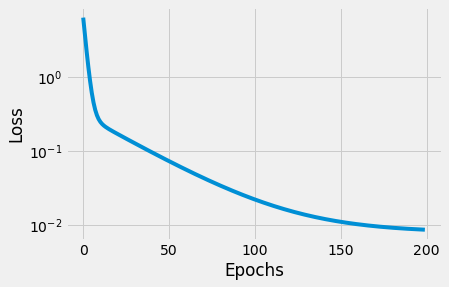

In [43]:
plt.plot(losses[:200])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

## Quiz

In [46]:
display_quiz('#./quiz/quiz4.b64')

# Exercise #4